#### Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import Dropout

2023-04-22 15:49:38.910024: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 15:49:38.917044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 15:49:39.064754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 15:49:39.066884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 15:49:41.957883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Pre-Processing

In [2]:
df = pd.read_csv('../Dataset/Mumbai.csv', skiprows = 15)
df.head()

,YEAR,MO,DY,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
0,1981,1,30,34.88,25.36,18.34,25.81,41.50,100.14,9.00
1,1981,1,31,31.22,23.47,18.56,24.36,59.75,100.24,13.45
2,1981,2,1,31.11,22.49,16.03,23.12,41.56,100.34,5.62
3,1981,2,2,33.58,22.40,13.62,23.51,26.38,100.24,-0.24
4,1981,2,3,35.51,24.05,15.30,25.16,30.12,100.16,2.97


In [3]:
df['YEAR'] = df.YEAR.astype(str)
df['MO'] = df.MO.astype(str)
df['DY'] = df.DY.astype(str)

df['dateTime'] = df['YEAR'].str.cat(df['MO'])
df['dateTime'] = df['dateTime'].str.cat(df['DY'])

df.drop(['YEAR', 'MO', 'DY'], axis=1, inplace=True)

In [4]:
df['dateTime'] = pd.to_datetime(df['dateTime'], format = '%Y%m%d')
df.set_index('dateTime', inplace = True)
df.head()

,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
dateTime,,,,,,,
1981-01-30,34.88,25.36,18.34,25.81,41.50,100.14,9.00
1981-01-31,31.22,23.47,18.56,24.36,59.75,100.24,13.45
1981-02-01,31.11,22.49,16.03,23.12,41.56,100.34,5.62
1981-02-02,33.58,22.40,13.62,23.51,26.38,100.24,-0.24
1981-02-03,35.51,24.05,15.30,25.16,30.12,100.16,2.97


In [5]:
df.rename(columns= {'T2M_MAX':'tempMax', 'T2M':'temp', 'T2M_MIN':'tempMin', 'TS':'earthSkin','RH2M':'relativeHumidity','PS':'pressure','T2MDEW':'dew'}, inplace = True)
df.head()

,tempMax,temp,tempMin,earthSkin,relativeHumidity,pressure,dew
dateTime,,,,,,,
1981-01-30,34.88,25.36,18.34,25.81,41.50,100.14,9.00
1981-01-31,31.22,23.47,18.56,24.36,59.75,100.24,13.45
1981-02-01,31.11,22.49,16.03,23.12,41.56,100.34,5.62
1981-02-02,33.58,22.40,13.62,23.51,26.38,100.24,-0.24
1981-02-03,35.51,24.05,15.30,25.16,30.12,100.16,2.97


In [6]:
X = df.drop('tempMax', axis = 1)

X.head()
X.shape

(15390, 6)

In [7]:
y = df['tempMax']
y


dateTime
1981-01-30    34.88
1981-01-31    31.22
1981-02-01    31.11
1981-02-02    33.58
1981-02-03    35.51
              ...  
2023-03-16    34.11
2023-03-17    35.81
2023-03-18    34.69
2023-03-19    32.97
2023-03-20    32.65
Name: tempMax, Length: 15390, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Architecture

In [10]:
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
#Output layer
model.add(Dense(1, activation = 'linear'))

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,729
Trainable params: 25,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train_scaled, y_train, validation_split=0.25, epochs =120)

Epoch 1/120
271/271 [==============================] - 6s 9ms/step - loss: 139.7462 - mae: 6.7406 - val_loss: 2.0417 - val_mae: 1.1130
Epoch 2/120
271/271 [==============================] - 2s 9ms/step - loss: 1.8574 - mae: 1.0582 - val_loss: 1.5937 - val_mae: 0.9764
Epoch 3/120
271/271 [==============================] - 2s 7ms/step - loss: 1.3856 - mae: 0.9120 - val_loss: 1.1808 - val_mae: 0.8408
Epoch 4/120
271/271 [==============================] - 1s 5ms/step - loss: 0.9725 - mae: 0.7607 - val_loss: 0.9048 - val_mae: 0.7321
Epoch 5/120
271/271 [==============================] - 2s 6ms/step - loss: 0.6549 - mae: 0.6209 - val_loss: 0.4734 - val_mae: 0.5226
Epoch 6/120
271/271 [==============================] - 1s 5ms/step - loss: 0.4698 - mae: 0.5209 - val_loss: 0.3926 - val_mae: 0.4871
Epoch 7/120
271/271 [==============================] - 1s 5ms/step - loss: 0.3899 - mae: 0.4759 - val_loss: 0.3215 - val_mae: 0.4223
Epoch 8/120
271/271 [==============================] - 1s 5ms/step 

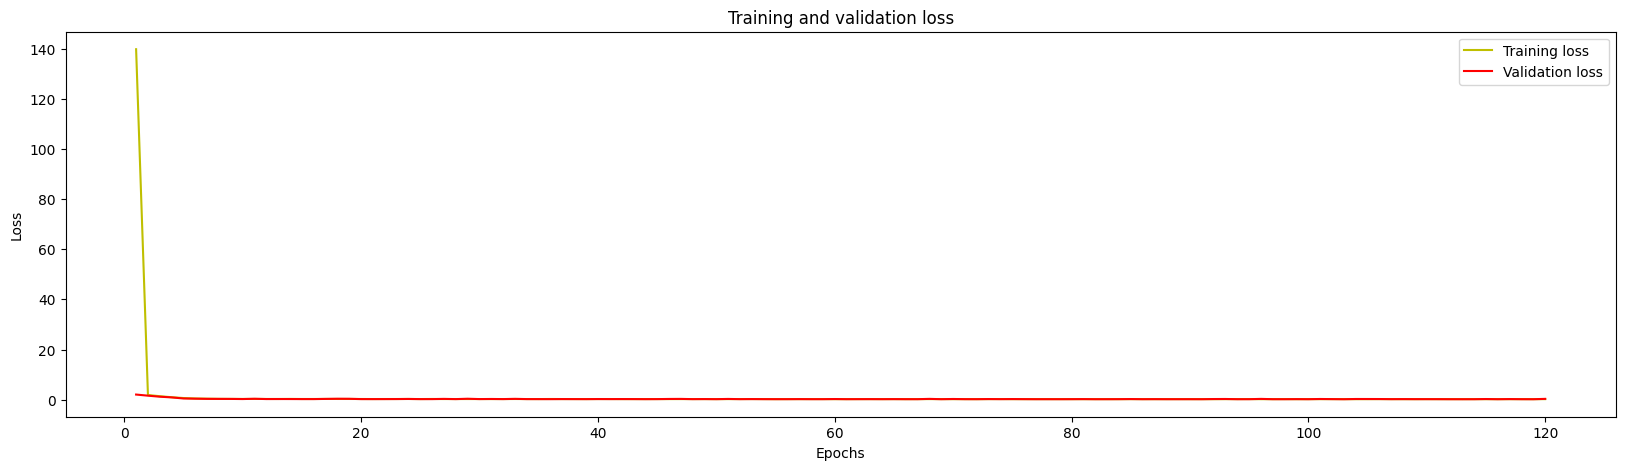

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

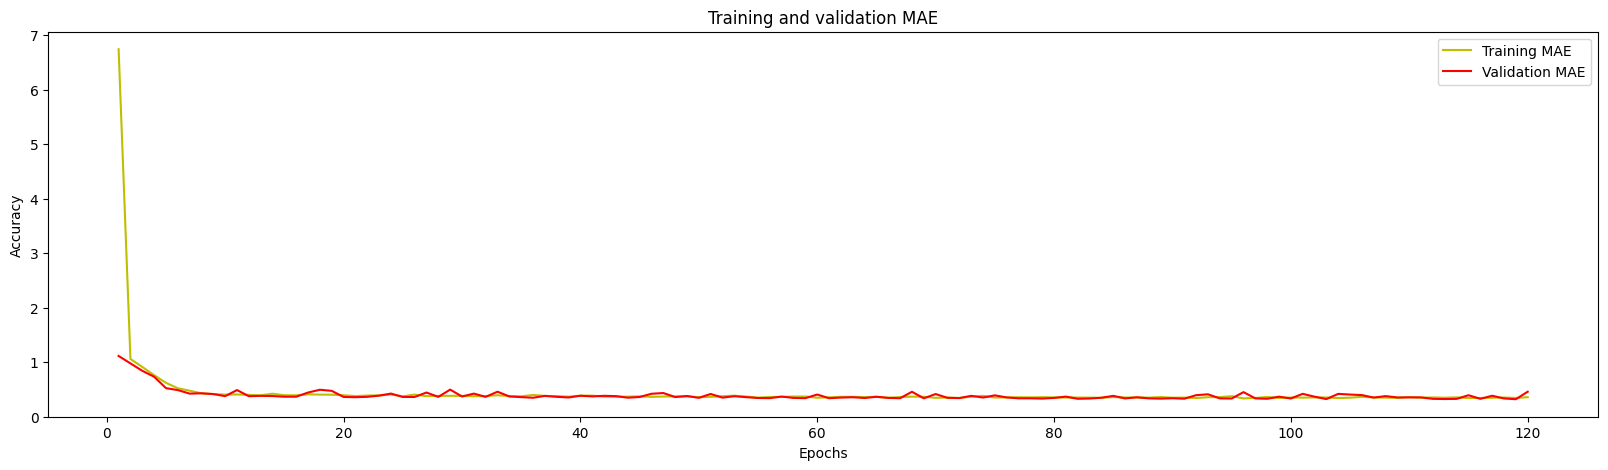

In [14]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Prediction

In [15]:
#Predict on test data
y_pred = model.predict(X_test_scaled)
print("Predicted values are: ", y_pred)
print("Real values are: ", y_test)

121/121 [==============================] - 0s 2ms/step
Predicted values are:  [[27.378344]
 [28.288553]
 [28.108418]
 ...
 [34.534374]
 [33.221184]
 [33.397354]]
Real values are:  dateTime
2012-09-06    27.77
2012-09-07    28.62
2012-09-08    28.78
2012-09-09    28.58
2012-09-10    28.20
              ...  
2023-03-16    34.11
2023-03-17    35.81
2023-03-18    34.69
2023-03-19    32.97
2023-03-20    32.65
Name: tempMax, Length: 3848, dtype: float64


In [16]:
T = range(y_pred.shape[0])

Text(0.5, 0, 'Values')

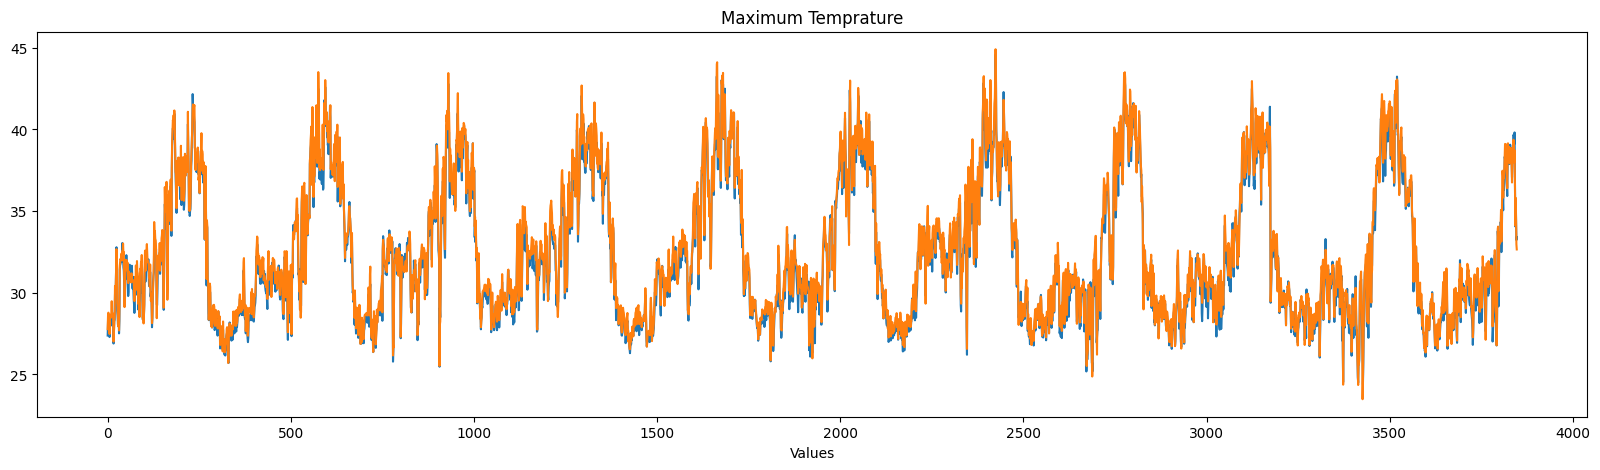

In [17]:
plt.plot(T, y_pred[:])
plt.plot(T, y_test[:])
plt.rcParams["figure.figsize"] = (200,50)
plt.title('Maximum Temprature')
plt.xlabel('Values')

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Temp_mae = mean_absolute_error(y_pred, y_test)
print(Temp_mae)

print(mean_squared_error(y_pred, y_test))
print(sqrt(mean_squared_error(y_pred, y_test)))

0.44310775082721027
0.30541036118082193
0.5526394495336194
